In [1]:
from utz import *
from ire import config, export, MD

In [2]:
ym = '202409'  # Month of data to read, process, and output (YYYYMM)
s3 = 's3:/'    # Read from S3; pass `../s3` or similar to read from a local path
drop = None    # Optional: extra columns to drop
table = None   # When set, save to SQLite instead of Parquet
per_page = 20  # Default rows per page to display in iRe/www

In [3]:
# Parameters
ym = 202408
drop = "rideable_type_duplicate_column_name_1"
table = "rides"


In [4]:
ym = YM(ym)
d = ym.date

In [5]:
df = pd.read_parquet(f'{s3}/ctbk/normalized/{ym}.parquet')

# Drop/Rename some columns
df = (
    df
    .drop(columns=[
        'Ride ID', 'Gender',
        *[
            f"{s} Station {n}"
            for s in [ 'Start', 'End' ]
            for n in [ 'ID', 'Latitude', 'Longitude' ]
        ],
        *(drop.split(',') if drop else []),
    ])
    .rename(columns={
        'Start Station Name': 'Start Station',
        'End Station Name': 'End Station',
    })
)

# Convert "User Type" col to "Subscriber" boolean
assert set(df['User Type'].unique()) == { 'Customer', 'Subscriber' }
df['Subscriber'] = df['User Type'] == 'Subscriber'
df = df.drop(columns='User Type')

# Convert "Rideable Type" col to "E-bike" boolean
assert set(df['Rideable Type'].unique()) == { 'electric_bike', 'classic_bike' }
df['E-bike'] = df['Rideable Type'] == 'electric_bike'
df = df.drop(columns='Rideable Type')

# Combine "Region" columns
def mk_region(r):
    start = r['Start Region']
    end = r['End Region']
    return start if start == end else f'{start} → {end}'
region_cols = ['Start Region', 'End Region']
df['Region'] = df[region_cols].apply(mk_region, axis=1)
df = df.drop(columns=region_cols)

# Sort by "Start Time"
df = df.sort_values('Start Time')

# Export
export(df, name=f'{ym}', table=table, per_page=per_page)

Saved sqlite to .ire/202408.db


In [6]:
by_day = df.groupby(df['Start Time'].dt.date).size().sort_index().rename('Rides')
by_day

Start Time
2024-08-01    166911
2024-08-02    144472
2024-08-03    138675
2024-08-04    115573
2024-08-05    157665
2024-08-06    117435
2024-08-07    111450
2024-08-08     97956
2024-08-09    124614
2024-08-10    182595
2024-08-11    154911
2024-08-12    153925
2024-08-13    168411
2024-08-14    174994
2024-08-15    173452
2024-08-16    167783
2024-08-17    160489
2024-08-18    117308
2024-08-19    144590
2024-08-20    167671
2024-08-21    170526
2024-08-22    169786
2024-08-23    168785
2024-08-24    167740
2024-08-25    147620
2024-08-26    144016
2024-08-27    168232
2024-08-28    164454
2024-08-29    162388
2024-08-30    149088
2024-08-31    139142
Name: Rides, dtype: int64

Saved plotly to .ire/202408-rides.json


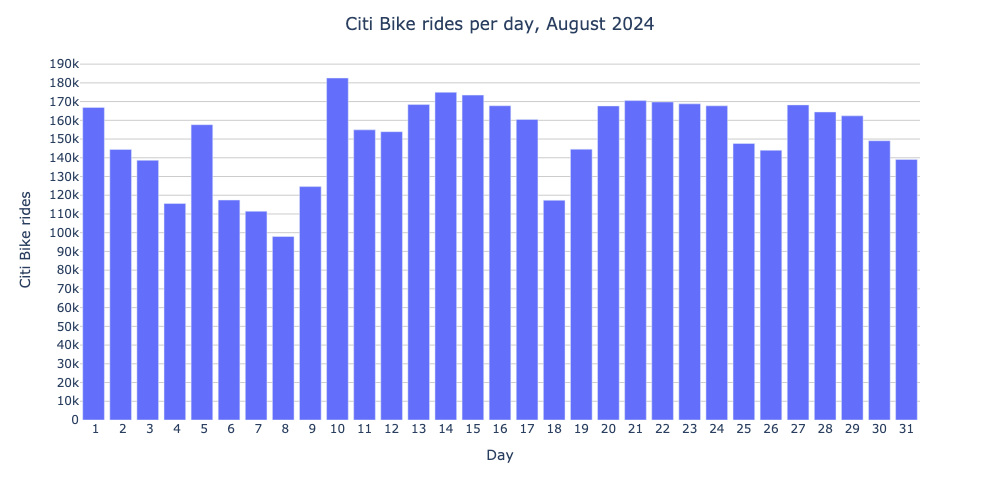

In [7]:
fig = plot(
    px.bar(by_day),
    title=f'Citi Bike rides per day, {d.strftime("%B %Y")}',
    bg='white', grid=None,
    hovertemplate='%{y:,}',
    margin=0,
    x=dict(
        dtick='d',
        tickformat='%e',
        title='Day',
    ),
    y=dict(
        dtick=10_000,
        title='Citi Bike rides',
        gridcolor='#ccc',
    ),
    legend=False,
    w=1000, h=500,
)
export(fig, name=f'{ym}-rides', dvc=False)